Copy 7 but change the two fit functions to match with the paper

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

from scipy import interpolate
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.signal import savgol_filter

from exocrires import info

from astropy.io import fits

import glob

path_a='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur'
path_b='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/thesis_ms'

In [31]:
'''
spec=np.loadtxt(path_a+'/upload_lowres.dat')
fMod = spec[:,1] #erg/s/cm^2/cm
fMod /= np.max(fMod)
wMod=spec[:,0] #m
'''


fMod=np.load(path_a+'/f_pRT_t2200_g31nc_m0.0.npy')
fMod /= np.nanmax(fMod)
wMod = np.load(path_a+'/wave_pRT_4.npy')
wMod = wMod * 1e-6 #m

lambda_range=info.lambda_range



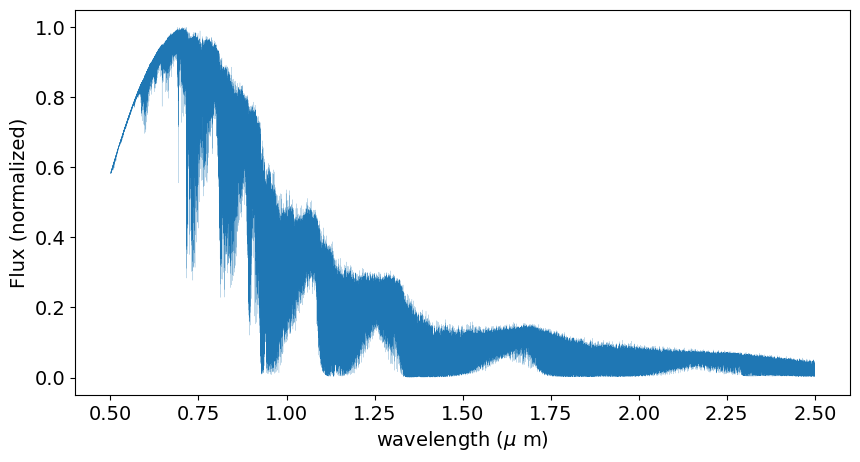

In [32]:
plt.rcParams.update({'font.size': 14})

fig=plt.figure(figsize=(10,5))
plt.plot(wMod*1e6, fMod, linewidth=0.1)
plt.xlabel('wavelength ($\mu$ m)')
plt.ylabel('Flux (normalized)')

#plt.xlim(1.0, 2.4)
#plt.ylim(0, 0.25)
plt.show()

## 0. Load the stacked mock observation and prepare the transmission cube

In [33]:
day='0611'
font = {'size': 20}
plt.rcParams.update({'font.size': font['size']})
model_name='22-3.5-0.0'
band='K2166'
path_file=path_a+'/%s/planet/%s/%s/noise_free'%(day, model_name,band)

stack=np.load(path_file+'/ABBA_stack_100x.npy')

tot_transmission=np.zeros(shape=(stack.shape[0],stack.shape[2],2))
atmos_transmission=np.zeros(shape=(stack.shape[0],stack.shape[2],2))
sky_emission=np.zeros(shape=(stack.shape[0],stack.shape[2],2))

for i in np.arange(29, 22, -1):

    index=0
    for j in range(1,4):
        #Do we use the total transmission or just the instrumental transmission ? What do we use in real observation ? 
        data_transmission=np.loadtxt(path_a+'/%s/star/K2166/ascii_35/converted_data_%s_throughput_totalinclsky_%s.txt'%(day, i,j),skiprows=1)
        data_atmos_transmission=np.loadtxt(path_a+'/%s/star/K2166/ascii_35/converted_data_%s_throughput_atmosphere_%s.txt'%(day, i,j),skiprows=1)
        emission=np.loadtxt(path_a+'/%s/star/K2166/ascii_35/converted_data_%s_signals_obssky_%s.txt'%(day, i,j),skiprows=1)
        
        tot_transmission[29-i][index*2046:(index+1)*2046]=data_transmission
        atmos_transmission[29-i][index*2046:(index+1)*2046]=data_atmos_transmission
        sky_emission[29-i][index*2046:(index+1)*2046]=emission

        index+=1
        
np.save(path_a+'/%s/sky_noi/K2166/transmission.npy'%day, tot_transmission)
np.save(path_a+'/%s/sky_noi/K2166/transmission_atmos.npy'%day, atmos_transmission)
np.save(path_a+'/%s/sky_noi/K2166/transmission_instrument.npy'%day, tot_transmission/atmos_transmission)
np.save(path_a+'/%s/sky_noi/K2166/sky_emission.npy'%day, sky_emission)

/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_1867/3452536433.py:31: RuntimeWarning: divide by zero encountered in divide
  np.save(path_a+'/%s/sky_noi/K2166/transmission_instrument.npy'%day, tot_transmission/atmos_transmission)
/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_1867/3452536433.py:31: RuntimeWarning: invalid value encountered in divide
  np.save(path_a+'/%s/sky_noi/K2166/transmission_instrument.npy'%day, tot_transmission/atmos_transmission)


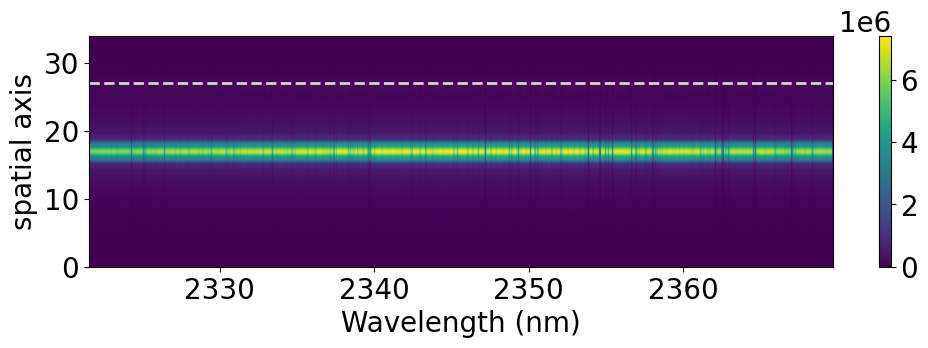

(7, 6144)


In [34]:
#path='/Volumes/Macintosh HD/Users/richard/project_EXOCRIRES/thesis_ms/spatial_pix05'
#filenames=np.sort(glob.glob(path+'/planet/*'))


d=10

#mask=np.array((parameter[:,0]==1400)&(parameter[:,1]==4.0))

lambda_range=info.lambda_range

#for file in filenames[mask]:
    
order_window=lambda_range['wave'][3]

mask=np.array((wMod*1e3>=order_window[-2][0])&(wMod*1e3<=order_window[-2][1]))

#wMod=wMod[mask]
#fMod=fMod[mask]

def plotMatrix(mat, xvec, yvec, xlab='',ylab='', stretch=False, planet_posi=None):
    if stretch:
        vmin = np.nanmean(mat)-np.nanstd(mat) * 8
        vmax = np.nanmean(mat)+np.nanstd(mat) * 8
    else:
        vmin = np.nanmin(mat)
        vmax = np.nanmax(mat)
    ext = [xvec[0],xvec[-1],yvec[0],yvec[-1]]

    plt.figure(figsize=(12,3))
    plt.imshow(mat, origin='lower', aspect='auto', extent=ext ,vmin=vmin, vmax=vmax)
    plt.hlines(y=planet_posi, xmin=xvec[0], xmax=xvec[1], ls='--', colors='lightgray', alpha=1, linewidth=2)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.colorbar()
    #plt.show()


def plotMatrix_sym(mat, xvec, yvec, xlab='',ylab='', stretch=False, planet_posi=None):
    if stretch:
        vmin = np.nanmean(mat)-np.nanstd(mat) * 8
        vmax = np.nanmean(mat)+np.nanstd(mat) * 8
    else:
        vmin = np.nanmin(mat)
        vmax = np.nanmax(mat)
    ext = [xvec[0],xvec[-1],yvec[0],yvec[-1]]

    plt.figure(figsize=(12,3))

    Norm = matplotlib.colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax, base=10**3)
    
    plt.imshow(mat, origin='lower', aspect='auto', extent=ext, norm=Norm)
    plt.hlines(y=planet_posi, xmin=xvec[0], xmax=xvec[1], ls='--', colors='lightgray', alpha=1, linewidth=2)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.colorbar()

plotMatrix(stack[-3], order_window[-2], np.arange(0, 35, 1), 'Wavelength (nm)', 'spatial axis', planet_posi=(17+d))
plt.show()

nDet=3 
nObs=35 
nPix=2048
nOrder=7
wlen = atmos_transmission[:,:,0]
print(wlen.shape)

#continuum proxy
medFlux=np.zeros(shape=(nDet*nOrder,35))

for order in range(nOrder):

    for i in range(nDet):

        medFlux[order*3+i]=np.median(stack[order, :, 2048*i:2048*(i+1)], axis=1)

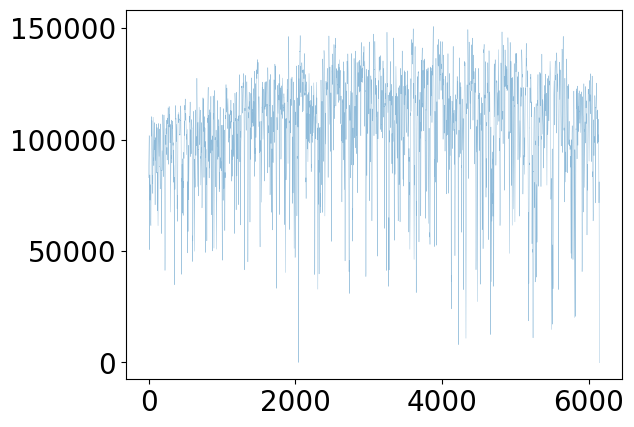

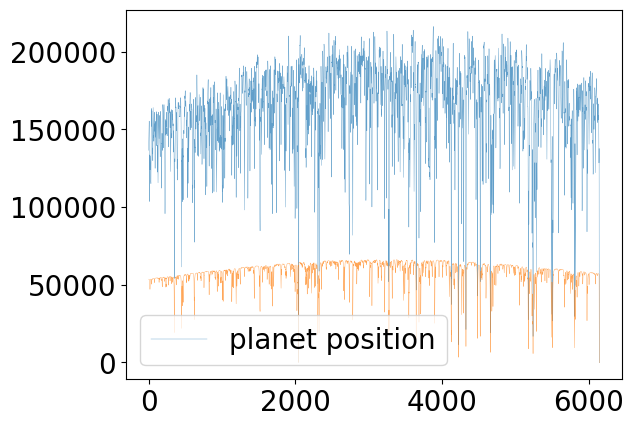

In [35]:
#first glimpse of the mock data to check the planet signal : F_planet - F_anti_planet
order=-3
plt.plot(stack[order][17+10,:]-stack[order][17-10,:],linewidth=0.3, alpha=0.5)

#k=np.nanmedian(stack[order][spatial_pix+10,:]-stack[order][spatial_pix-10,:])/np.nanmedian(fMod)

#plt.plot(fMod*k,linewidth=0.3, alpha=0.9, label='fMod')
#plt.plot(stack[order][spatial_pix-10,:],label='anti')

plt.show()

plt.plot(stack[order][17+10,:],linewidth=0.3, alpha=0.7, label='planet position')
plt.plot(stack[order][17-10,:],linewidth=0.3, alpha=0.7)
plt.legend()
plt.show()

## 1. Masking
Low Transmission Masking and bad-pixel masking

In [36]:
font = {'size': 20}
plt.rcParams.update({'font.size': font['size']})
model_name='22-3.5-0.0'
band='K2166'
#path_file=path_a+'/%s/planet/%s/%s/noise_free'%(model_name,band)
d=10

transmission_instrument=np.load(path_a+'/%s/sky_noi/K2166/transmission_instrument.npy'%day)
transmission_atmos=np.load(path_a+'/%s/sky_noi/K2166/transmission_atmos.npy'%day)
sky_emission=np.load(path_a+'/%s/sky_noi/K2166/sky_emission.npy'%day)

#mask the bad pixels and the low transmission ranges

atm_threshold=0.6
sigma_threshold=4

for i in range(stack.shape[0]):

    low_atmos_transmission_mask=np.where((transmission_atmos[i,0:2046*3,1])<atm_threshold, True, False)

    for j in range(stack.shape[1]):

        mean_flux=np.nanmean(stack[i,j,0:2046*3])
        std_flux =np.nanstd(stack[i,j,0:2046*3])

    

        bad_pixel_mask=np.where((np.abs(stack[i,j,0:2046*3] - mean_flux) > (sigma_threshold * std_flux)),True, False)
        

        stack[i,j,0:2046*3][bad_pixel_mask]=np.nan
  
        stack[i,j,0:2046*3][low_atmos_transmission_mask]=np.nan

       
    
#stack_sub_tel[np.isinf(stack_sub_tel)]=0.
#stack_sub_tel[np.isnan(stack_sub_tel)]=0.

# maxmimum normalization 
#inf_mask=np.isinf(stack)
#stack_correct_instrument/=np.nanmax(stack[~inf_mask])

np.save(path_file+'/stack_sub_badpix_100x.npy', stack)

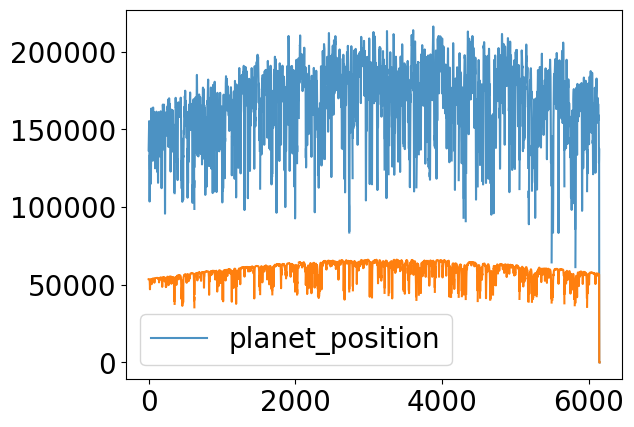

(-0.5, 1.0)

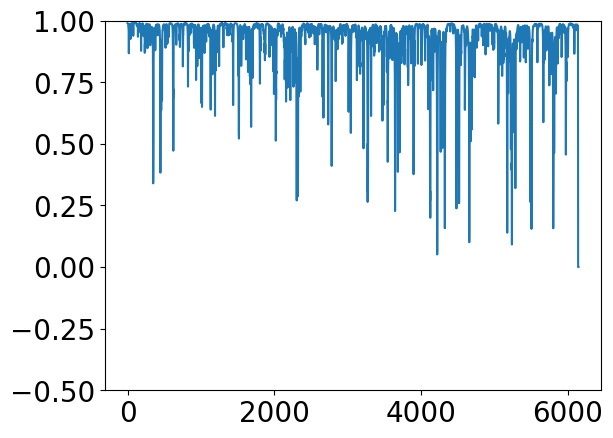

In [37]:
#plt.plot(stack_sub_tel[order,spatial_pix])
#plt.ylim(1e6,8e7)

plt.plot(stack[order,17+10],label='planet_position', alpha=0.8)
plt.plot(stack[order,17-10])

#plt.plot(stack[order,spatial_pix])
#plt.yscale('log')
plt.legend()
plt.show()

plt.plot(transmission_atmos[order,:,1])
plt.ylim(-0.5,1)

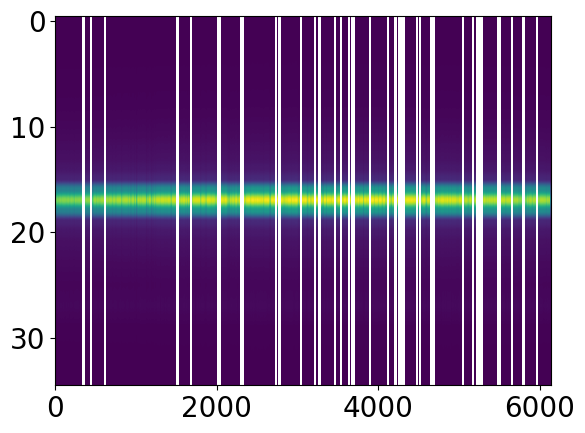

In [38]:
plt.imshow(stack[order], aspect='auto')
plt.show()

## 2.Starlight Subtraction

## Approach C: Fitting with a multiplicative factor
1. Extract the transmission profiles by dividing a PHOENIX model from the central pixel (assuming only the starlight and , as Landaman et al., 2023 excuted 
2. Correct the overall throughput with the extracted transmission profile ? --- We don't correct the overall throughput in the beginning. Instead we strictly follow Landman's approach. 
3. Inplement the low-pass ratio to normalize based on the continuum ratio between the observation and the model
4. Fit and subtract the starlight with a multiplicative factor

### 2.1 Extract the transmission profile and write in a matrix

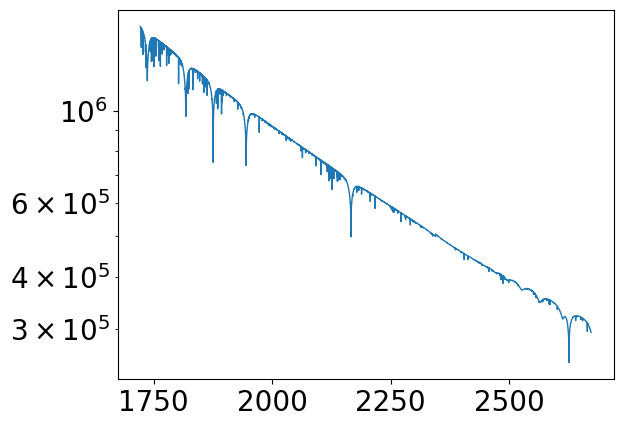

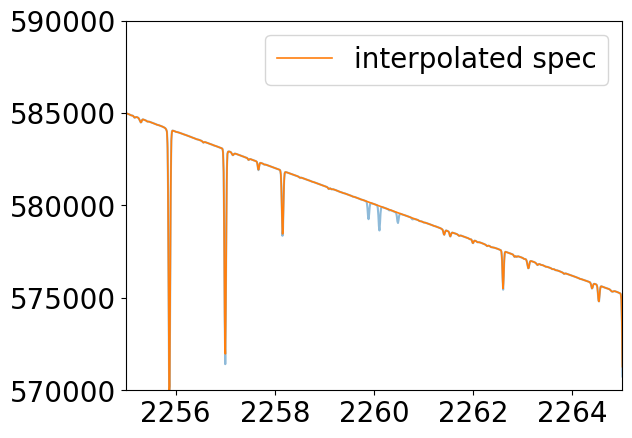

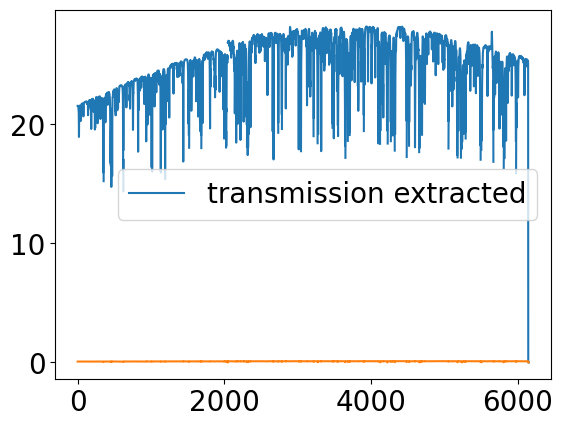

In [39]:
#Extract the transmission profile

stack_sub_badpix=np.load(path_file+'/stack_sub_badpix_100x.npy')
model_matrix_star=np.zeros(shape=(stack_sub_badpix.shape[0],stack_sub_badpix.shape[2]))

master_matrix=np.zeros(shape=(stack_sub_badpix.shape[0],stack_sub_badpix.shape[2]))
central_pix=17
order=-3

#generate the master templates from bad_pixel removed spectra
for i in range(stack_sub_badpix.shape[0]):
    
    for x in range(3):
        
        master=stack_sub_badpix[i,central_pix][x*2046:(x+1)*2046]
        master_int=np.trapz(stack_sub_badpix[i, 15:20,x*2046:(x+1)*2046], axis=0)

        master_matrix[i, x*2046:(x+1)*2046]=master_int

#generate the model matrix of the star
phoenix_spec=np.loadtxt(path_a+'/upload_phoenix_K2166.dat')
spec=phoenix_spec[:,1]
wave=phoenix_spec[:,0]

wave*=1e9

plt.plot(wave, spec, linewidth=1)
#plt.xlim(1e3, 4e3)
#plt.ylim(1e12, 1e15)
plt.yscale('log')
plt.show()

wave_range=lambda_range['wave'][-2]

for i in range(stack_sub_badpix.shape[0]):

    mask=np.array((wave>=wave_range[i][0])&(wave<=wave_range[i][1]))

    spec_inter=np.interp(transmission_atmos[i,0:2046*3,0]*1e9, wave[mask], spec[mask])

    model_matrix_star[i][0:2046*3]=spec_inter


    
#division and normalization
transmission_matrix = np.zeros(shape=master_matrix.shape)

for i in range(master_matrix.shape[0]):
    
    trans = master_matrix[i,0:3*2046]/model_matrix_star[i, 0:3*2046]

    #trans /= np.nanmax(trans)

    transmission_matrix[i, 0:3*2046]=trans

mask=np.array((wave>=wave_range[order][0])&(wave<=wave_range[order][1]))

plt.plot(wave[mask], spec[mask], linewidth=1.5, alpha=0.5)
plt.plot(transmission_atmos[order, 0:2046*3, 0]*1e9, model_matrix_star[order][0:2046*3], linewidth=1.2, label='interpolated spec')
plt.ylim(0.57e6, 0.59e6)
plt.xlim(2255, 2265)

plt.legend()
plt.show()

plt.plot(transmission_matrix[order], label='transmission extracted')
plt.plot(tot_transmission[order,:,1])
#plt.ylim(8e5, 8.5e5)
#plt.xlim(0,2000)
plt.legend()
plt.show()

### 2.2 Fit the stellar contribution and the planet contribution

In [40]:
#stack=np.load(path_file+'/ABBA_stack.npy')
stack=np.load(path_file+'/stack_sub_badpix_100x.npy')
stack_planet_fit=np.zeros(shape=stack.shape)
model_matrix_planet=np.load(path_file+'/ABBA_stack_planetonly_100x.npy')
planet_model=np.load(path_file+'/model_planet_matrix_10km.npy')

window=300

def fit_star(c, master, observation, transmission, window_length, polyorder):

    smoothed_master = savgol_filter(master, window_length, polyorder)

    smoothed_obs = savgol_filter(observation, window_length, polyorder)

    

    alpha_1 = smoothed_obs/smoothed_master
    #alpha=1
    
    stellar_real_obs = c*alpha_1*master

    stellar_subtracted = stellar_real_obs/transmission
    
    return (stellar_real_obs, stellar_subtracted, alpha_1)


def fit_planet(c, master, transmission, spec_planet, model_planet, window_length, polyorder):

    
    smoothed_master = savgol_filter(master, window_length, polyorder)
    
    smoothed_planet = savgol_filter(transmission*spec_planet, window_length, polyorder)

    alpha_2 = smoothed_planet/smoothed_master


    
    planet_obs = c*transmission*spec_planet 

    planet_leakage=c*master*alpha_2

    planet_real_obs = planet_obs - planet_leakage
    
    return (planet_obs, planet_real_obs, planet_leakage, alpha_2)

popt_list=np.zeros(shape=(stack.shape[0], stack.shape[1], 3, 2))


fit_matrix_planet=np.zeros(shape=(stack.shape))
fit_matrix_planet_non_correct=np.zeros(shape=(stack.shape))
fit_alpha_planet=np.zeros(shape=(stack.shape))

fit_matrix_star=np.zeros(shape=(stack.shape))
fit_alpha_star=np.zeros(shape=(stack.shape))

                           
for i in range(2,stack.shape[0]):
    
    for x in range(3):
        
        master=stack[i,central_pix][x*2046:(x+1)*2046]
        master_int=np.trapz(stack[i,16:19,x*2046:(x+1)*2046], axis=0)
        mask=np.isfinite(master_int)

        for j in range(stack.shape[1]): 

            mask_data = np.isfinite(stack[i,j][x*2046:(x+1)*2046])

            def wrap_model(master_wrap, cs, cp):

                wrap_star = fit_star(cs, master_wrap, stack[i,j, x*2046:(x+1)*2046][mask&mask_data], transmission_matrix[i,x*2046:(x+1)*2046][mask&mask_data],window,2)

                wrap_planet = fit_planet(cp, master_wrap, transmission_matrix[i,x*2046:(x+1)*2046][mask&mask_data], planet_model[i, x*2046:(x+1)*2046, 1][mask&mask_data], model_matrix_planet[i, j, x*2046:(x+1)*2046][mask&mask_data], window,2)
 
                wrapped_model = wrap_star[0] + wrap_planet[1]
                
                return (wrapped_model)

            popt, pcov = curve_fit(wrap_model, master_int[mask&mask_data], stack[i,j,x*2046:(x+1)*2046][mask&mask_data])
            popt_list[i,j,x]=popt
            
            #------
            star_contribution = fit_star(popt[0], master_int[mask&mask_data], observation=stack[i, j, x*2046:(x+1)*2046][mask&mask_data], transmission=transmission_matrix[i,x*2046:(x+1)*2046][mask&mask_data], window_length=window, polyorder=2)
            
            planet_contribution = fit_planet(popt[1], master_int[mask&mask_data], transmission_matrix[i,x*2046:(x+1)*2046][mask&mask_data], spec_planet=planet_model[i, x*2046:(x+1)*2046, 1][mask&mask_data], model_planet=model_matrix_planet[i, j, x*2046:(x+1)*2046][mask&mask_data], window_length=window, polyorder=2)

            
            fit_matrix_planet[i,j][x*2046:(x+1)*2046][mask&mask_data]=planet_contribution[1]
            fit_matrix_planet_non_correct[i,j][x*2046:(x+1)*2046][mask&mask_data]=planet_contribution[0]
            #fit_matrix_star[i,j][x*2046:(x+1)*2046][mask&mask_data]=star_contribution[0]-planet_contribution[2]
            fit_matrix_star[i,j][x*2046:(x+1)*2046][mask&mask_data]=star_contribution[0]
            
            fit_alpha_star[i,j][x*2046:(x+1)*2046][mask&mask_data]=star_contribution[2]
            fit_alpha_planet[i,j][x*2046:(x+1)*2046][mask&mask_data]=planet_contribution[3]
            
            print (popt)

#normalization

np.save(path_file+'/stack_star_fit.npy', fit_matrix_star)
np.save(path_file+'/stack_planet_fit.npy', fit_matrix_planet)

[1.00000000e+00 1.22156624e-10]
[1.00000000e+00 1.21500167e-10]
[1.00000000e+00 2.00525138e-10]
[1.00000000e+00 1.52982392e-10]
[1.00000000e+00 3.07320826e-10]
[1.00000000e+00 2.04490278e-10]
[1.00000000e+00 3.58561256e-10]
[1.00000000e+00 4.35797385e-10]
[1.00000000e+00 3.62361942e-10]
[1.00000000e+00 4.28435836e-10]
[1.00000e+00 3.51198e-10]
[1.00000000e+00 3.62903011e-10]
[1.00000000e+00 4.83489971e-10]
[1.00000000e+00 5.30479141e-10]
[1.0000000e+00 4.6170118e-10]
[1.00000000e+00 4.91931333e-10]
[1.00000000e+00 6.49601669e-10]
[1.00000000e+00 4.86953766e-09]
[1.00000000e+00 6.49601669e-10]
[0.99999999 0.00161442]
[0.99999998 0.002259  ]
[0.99999996 0.00308025]
[0.99999992 0.00430692]
[0.99999986 0.00551377]
[0.99999973 0.00799436]
[0.99999949 0.01138273]
[0.99999799 0.04590318]
[0.99999678 0.09105107]
[0.99999727 0.04590318]
[0.99999868 0.01138273]
[0.99999877 0.00799436]
[0.9999989  0.00551377]
[0.99999892 0.00430692]
[0.99999901 0.00308025]
[0.99999911 0.002259  ]
[ 1.00000000e+00

/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_1867/2691978374.py:79: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(wrap_model, master_int[mask&mask_data], stack[i,j,x*2046:(x+1)*2046][mask&mask_data])


[0.99999965 0.00786933]
[0.99999929 0.01148374]
[0.9999964  0.04744539]
[0.99999267 0.09413537]
[0.99999441 0.04744539]
[0.99999793 0.01148374]
[0.99999813 0.00786933]
[0.99999835 0.00549753]
[0.99999837 0.00432089]
[0.99999854 0.00309544]
[0.99999869 0.00227145]
[ 1.00001391e+00 -4.96875688e-06]
[ 1.00001401e+00 -6.04661101e-06]
[ 1.00001480e+00 -7.95075692e-06]
[ 1.00001387e+00 -9.36018487e-06]
[ 1.00001499e+00 -1.26780955e-05]
[ 1.00001494e+00 -1.65097164e-05]
[ 1.00001486e+00 -2.10075205e-05]
[ 1.00001421e+00 -2.69410456e-05]
[ 1.00001531e+00 -3.75005060e-05]
[ 1.00001536e+00 -5.13115574e-05]
[ 1.00001455e+00 -6.85505896e-05]
[ 1.00001617e+00 -1.03664811e-04]
[ 1.00001679e+00 -1.49863856e-04]
[ 1.00002095e+00 -2.35056983e-04]
[ 1.00002416e+00 -3.78699580e-04]
[ 1.00000755e+00 -1.81116878e-04]
[9.99994703e-01 5.48077815e-04]
[ 1.00000267e+00 -5.48074900e-04]
[9.99994703e-01 5.48077815e-04]
[ 1.00000851e+00 -2.28234155e-04]
[ 1.00002615e+00 -4.45079656e-04]
[ 1.00002475e+00 -3.255338

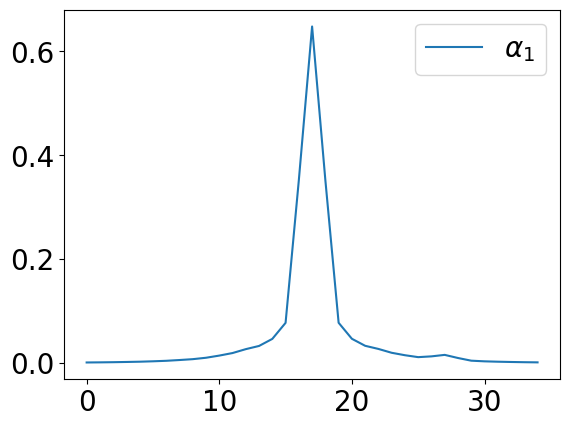

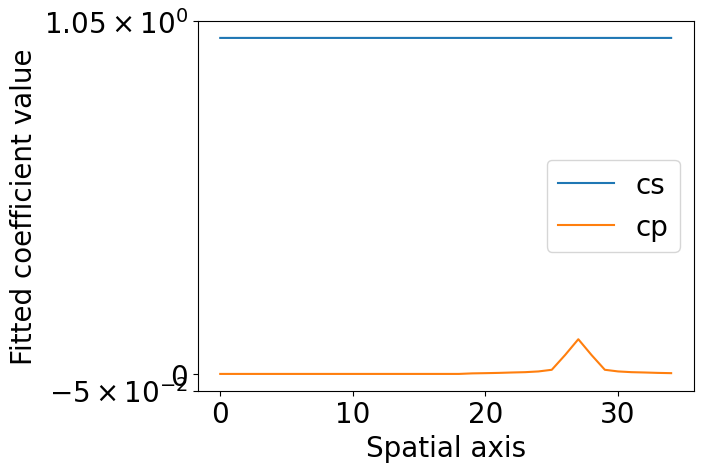

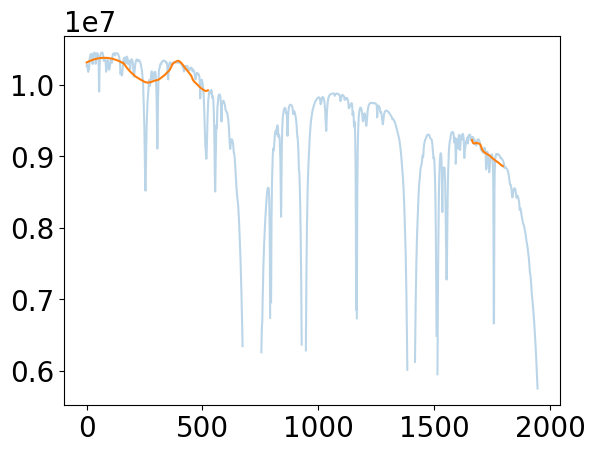

In [41]:
multi_factor=(fit_alpha_star[-3,:, 0:2046].T*popt_list[-3, :, 0, 0])

#plt.plot(multi_factor[1000],label=r'$c_s\alpha (\lambda)$')
plt.plot(fit_alpha_star[-3,:,1000], label=r'$\alpha_1$')
#plt.vlines(x=17, ymin=0, ymax=3e-2, ls='--')
#plt.vlines(x=27, ymin=0, ymax=3e-2, ls='--')
#plt.ylim(0.647,0.649)
#plt.xlim(1000,1010)
plt.legend()
plt.show()


plt.plot(popt_list[-3, :, 0], label=['cs', 'cp'])
#plt.hlines(y=1, xmin=0, xmax=35, ls='--', colors='gray')
#plt.vlines(x=27, ymin=0, ymax=1, ls='--')
plt.xlabel('Spatial axis')
plt.ylabel('Fitted coefficient value')
plt.yscale('symlog')
plt.legend()
plt.show()

test_master=savgol_filter(master_int, window, polyorder=2)
plt.plot(master_int, alpha=0.3)
plt.plot(test_master, label='lowpass')

plt.show()

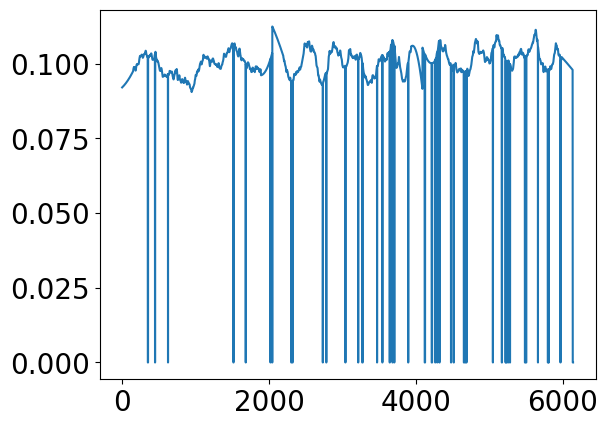

In [42]:
plt.plot(fit_alpha_planet[-3, 27])
#plt.ylim(0.64, 0.66)

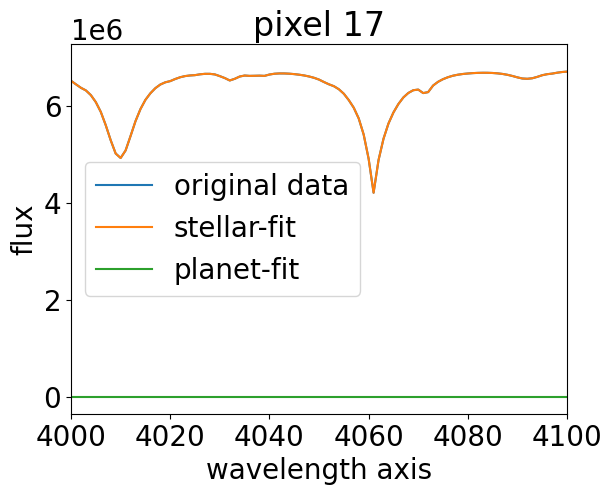

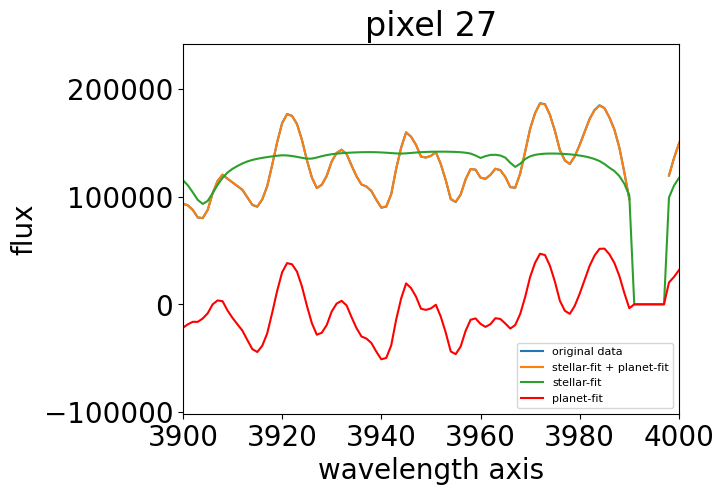

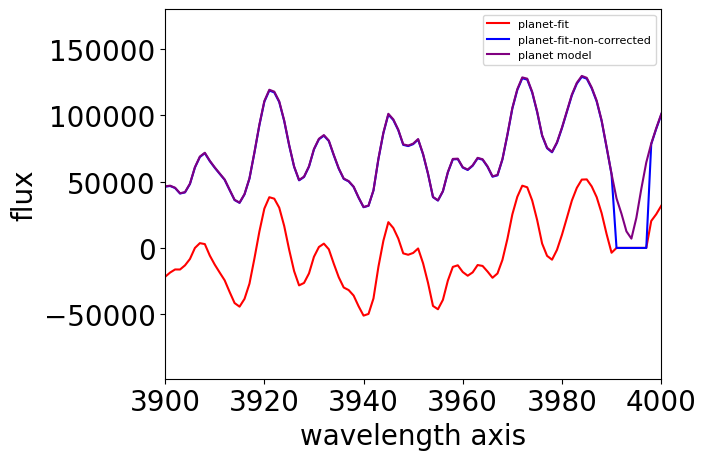

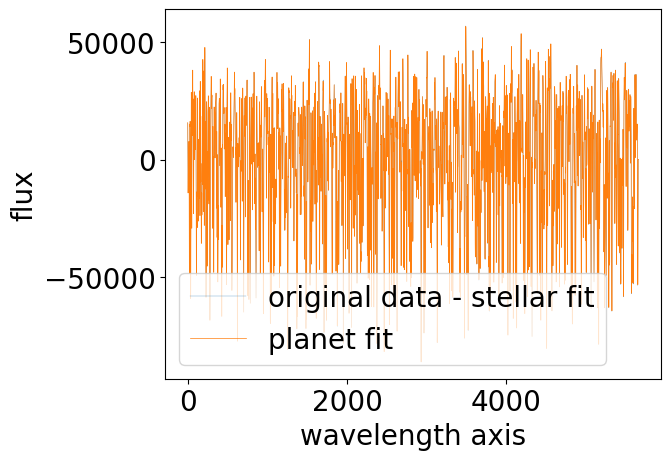

In [43]:
order=-2
central_pix=17
spatial_pix=27

mask_data = np.isfinite(stack[order,central_pix])

plt.title('pixel %s'%central_pix)

plt.plot(stack[order,central_pix][mask_data], label='original data')
plt.plot(fit_matrix_star[order, central_pix][mask_data], label='stellar-fit')
plt.plot(fit_matrix_planet[order, central_pix][mask_data], label='planet-fit')

plt.xlim(4000,4100)

plt.xlabel('wavelength axis')
plt.ylabel('flux')

plt.legend()
plt.show()

plt.title('pixel %s'%spatial_pix)
plt.plot(stack[order,spatial_pix],label='original data')
fit_matrix=fit_matrix_star[order, spatial_pix]+fit_matrix_planet[order, spatial_pix]
mask_fit=np.array(fit_matrix==0.)

fit_matrix[mask_fit]=np.nan

plt.plot(fit_matrix, label='stellar-fit + planet-fit')
plt.plot(fit_matrix_star[order, spatial_pix], label='stellar-fit')

plt.plot(fit_matrix_planet[order, spatial_pix], label='planet-fit',c='red')

plt.xlim(3900,4000)

plt.xlabel('wavelength axis')
plt.ylabel('flux')

plt.legend(fontsize=8)
plt.show()

plt.plot(fit_matrix_planet[order, spatial_pix], label='planet-fit', c='red')
plt.plot(fit_matrix_planet_non_correct[order, spatial_pix], label='planet-fit-non-corrected', c='blue')
plt.plot(model_matrix_planet[order, spatial_pix], label='planet model', c='purple')

plt.xlim(3900,4000)

plt.xlabel('wavelength axis')
plt.ylabel('flux')

plt.legend(fontsize=8)
plt.show()

plt.plot(stack[order,spatial_pix][mask_data]-fit_matrix_star[order, spatial_pix][mask_data],label='original data - stellar fit', linewidth=0.2)
plt.plot(fit_matrix_planet[order, spatial_pix][mask_data],label='planet fit', linewidth=0.5)

#plt.ylim(1e4, 1.5e5)

plt.xlabel('wavelength axis')
plt.ylabel('flux')


plt.legend()
plt.show()


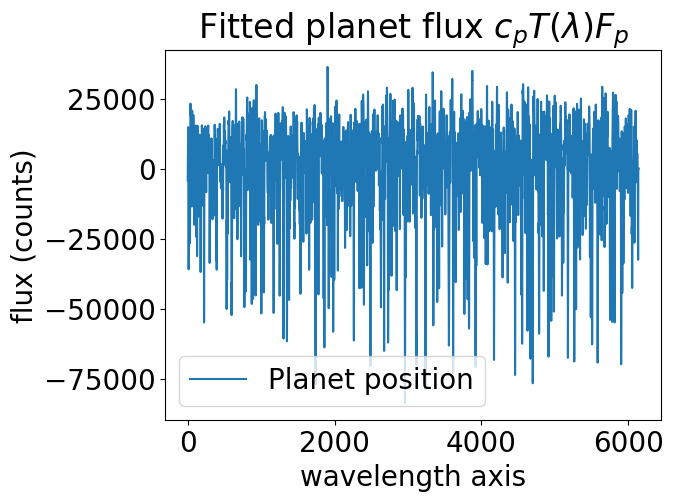

In [44]:
plt.plot(fit_matrix_planet[-3, 27], label='Planet position')
plt.xlabel('wavelength axis')
plt.ylabel('flux (counts)')
plt.title('Fitted planet flux $c_p T(\lambda) F_p$')
plt.legend()

plt.show()

/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_1867/683104954.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot((stack[order,i]-fit_matrix_star[order,i])/fit_matrix_star[order, i], label='%s'%i, alpha=0.3)


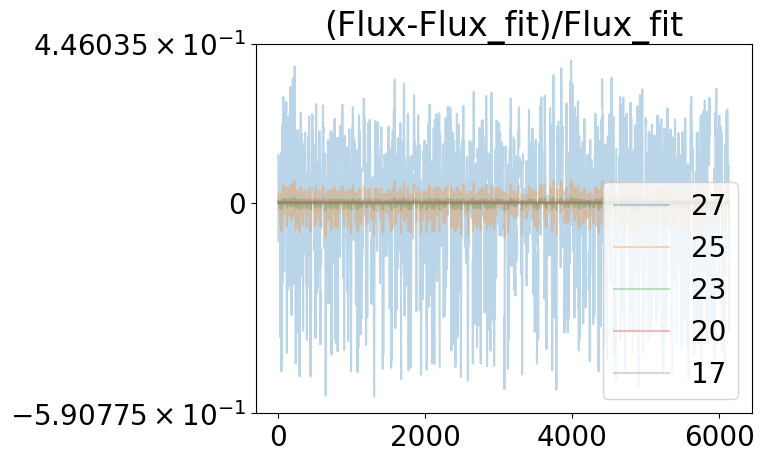

/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_1867/683104954.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


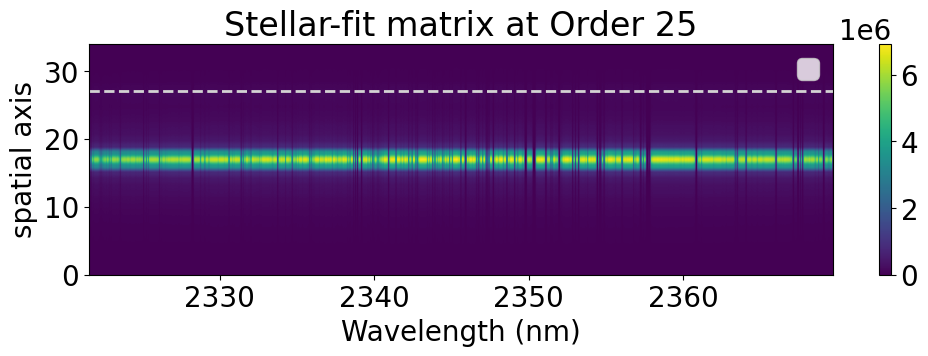

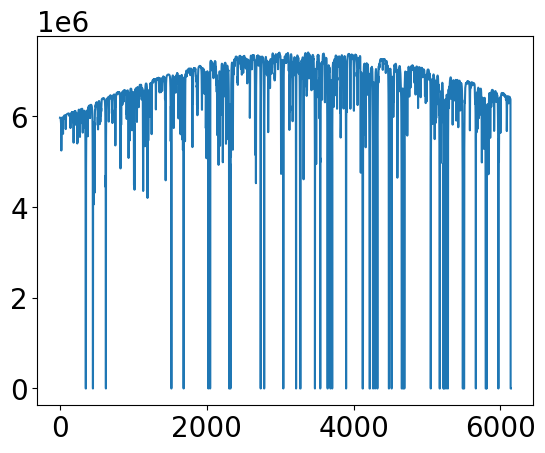

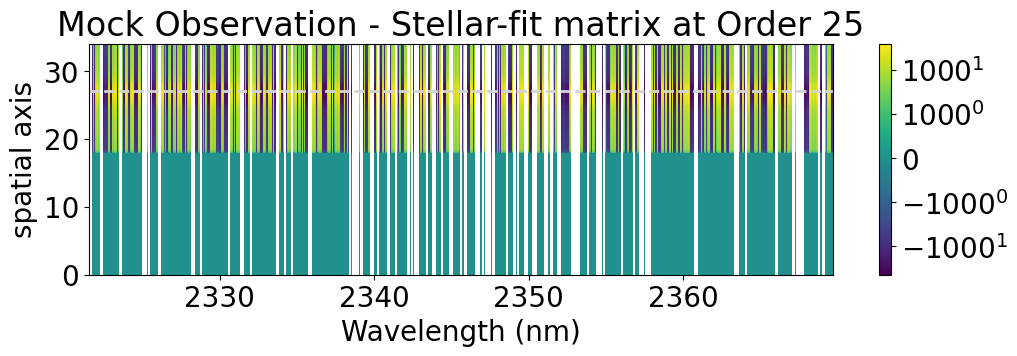

<Figure size 640x480 with 0 Axes>

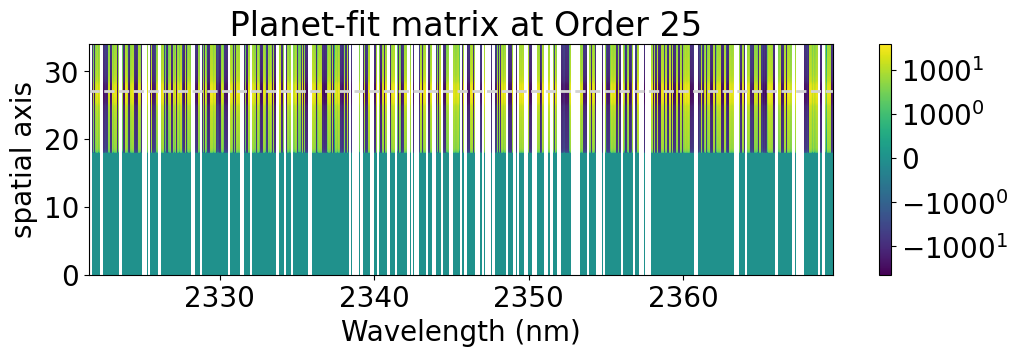

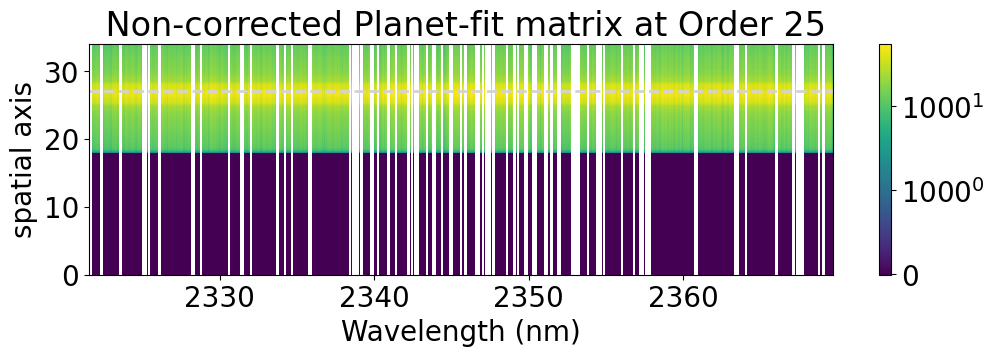

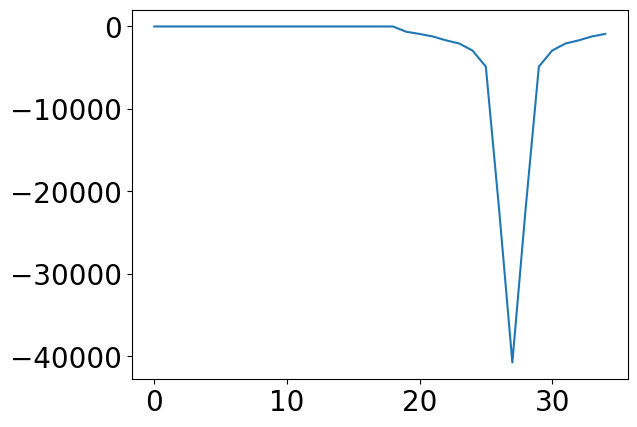

In [45]:
#plt.plot(stack[-1, 18, 2048*2:2048*3])

for i in [17, 20, 23, 25, 27][::-1]:
    
    plt.plot((stack[order,i]-fit_matrix_star[order,i])/fit_matrix_star[order, i], label='%s'%i, alpha=0.3)
    #plt.plot((fit_martix[order, 27]-stack[order, 27])/stack[order, 27], label='27', alpha=0.3)
plt.yscale('symlog')
#plt.ylim(-1,1)
#plt.xlim(0, 500)
plt.title('(Flux-Flux_fit)/Flux_fit')
plt.legend()
plt.show()

plotMatrix(fit_matrix_star[order], order_window[-2], np.arange(0, 35, 1), 'Wavelength (nm)', 'spatial axis', planet_posi=(17+d))
plt.title('Stellar-fit matrix at Order 25')
plt.legend()
plt.show()


plt.plot(fit_matrix_star[-3,17])
plt.show()

subtract=stack-fit_matrix_star
mask_sub=np.isfinite(subtract)
subtract[~mask_sub]=np.nan
fit_matrix_planet[~mask_sub]=np.nan
fit_matrix_planet_non_correct[~mask_sub]=np.nan

plotMatrix_sym(subtract[order], order_window[-2], np.arange(0, 35, 1), 'Wavelength (nm)', 'spatial axis', planet_posi=(17+d))
plt.title('Mock Observation - Stellar-fit matrix at Order 25')
plt.show()

plt.savefig(path_file+'/mock_stellar.png', dpi=150)

plotMatrix_sym(fit_matrix_planet[order], order_window[-2], np.arange(0, 35, 1), 'Wavelength (nm)', 'spatial axis', planet_posi=(17+d))
plt.title(' Planet-fit matrix at Order 25')
plt.show()

plotMatrix_sym(fit_matrix_planet_non_correct[order], order_window[-2], np.arange(0, 35, 1), 'Wavelength (nm)', 'spatial axis', planet_posi=(17+d))
plt.title(' Non-corrected Planet-fit matrix at Order 25')
plt.show()

plt.plot(fit_matrix_planet[-3, :, 600])
plt.show()


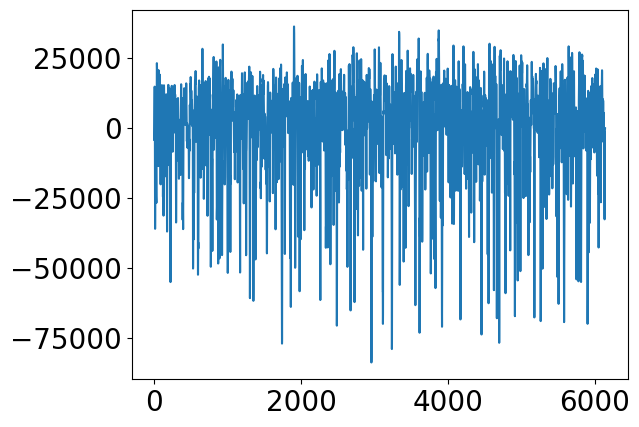

In [62]:
plt.plot(fit_matrix_planet[-3][27,:])

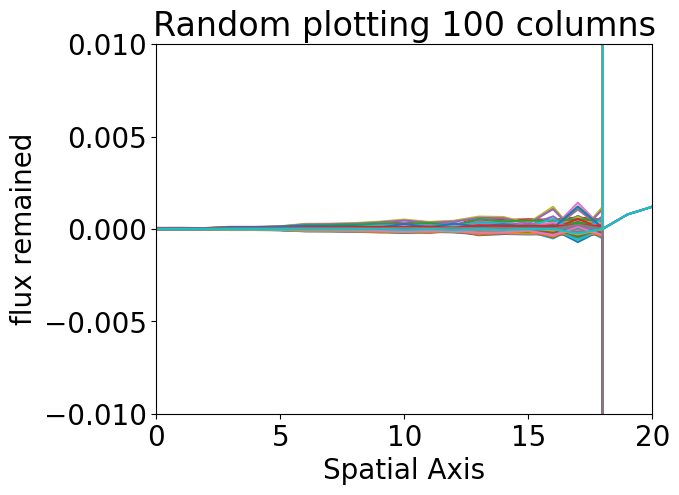

In [70]:

int_ran=np.random.randint(0, 6144, size=100)
for i in int_ran:
    plt.plot(fit_matrix_planet[order,:, i])

plt.xlabel('Spatial Axis')
plt.ylabel('flux remained')
plt.vlines(x=spatial_pix, ls='--', colors='Gray',ymin=0,ymax=1)
plt.xlim(0,20)
plt.ylim(-0.01,0.01)

plt.title('Random plotting 100 columns')
plt.show()

## 3. Cross-correlation

In [47]:
font = {'size': 20}
plt.rcParams.update({'font.size': font['size']})
model_name='22-3.5-0.0'
band='K2166'
path_file=path_a+'/%s/planet/%s/%s'%(day,model_name,band)

#stack_planet_fit=np.load(path_file+'/stack_planet_fit.npy')
#stack_star_fit=np.load(path_file+'/stack_star_fit.npy')

def xcorr(f,g):
    nx = len(f)
    I = np.ones(nx)
    f -= np.dot(f,I)/nx
    g -= np.dot(g,I)/nx
    R = np.dot(f,g)/nx
    varf = np.dot(f,f)/nx
    varg = np.dot(g,g)/nx
    return R / np.sqrt(varf*varg)

''' Defining lag vector '''
'''
nDet=3
nPix=2048
'''
nDet=5
nPix=6144

ncc = 150            # Number of cross correlation values
dRV = 1
rvlag = (np.arange(ncc) - (ncc-1)//2) * dRV     # RV lag centred around zero and with step 1.5 km/s
print(rvlag[0],rvlag[-1])

''' Exploring the the CCF grid '''
''' Example of faster version '''

def get_cc_grid(wMod, fMod, wlen, cube):
    ccf = np.zeros((nDet,nObs,ncc))
    coef_spline = interpolate.splrep(wMod, fMod, s=0.0)
    for irv, rv in enumerate(rvlag):
        beta = rv / 2.998E5
        # Shifting data wlen instead by swapping sign of RV
        wShift = wlen * np.sqrt( (1-beta) / (1+beta) )  # A (nDet,nPix) vector
        intMod = interpolate.splev(wShift,coef_spline,der=0) # A (nDet,nPix) vector
        for iDet in range(nDet):
            for iObs in range(nObs):
                ccf[iDet,iObs,irv] = xcorr(cube[iDet,iObs,], intMod[iDet,])
    return ccf

import time as tim

'''
order_i=np.zeros(shape=(nDet, stack_sub_tel_star.shape[1], 2048))

for i in range(nDet):
    order_i[i]=stack_sub_tel_star[-2][:, 2048*i:2048*(i+1)]
'''
#mask=np.isfinite(subtract)
mask=np.isfinite(fit_matrix_planet_non_correct)
#subtract[~mask]=0.0
fit_matrix_planet[~mask]=0.0


mask_model=np.array(wMod*1e9>wave_range[1][1])


t0 = tim.time()
ccf = get_cc_grid(wMod[mask_model], fMod[mask_model], wlen[2:], fit_matrix_planet[2:])
print('Cross correlation cube computed in {:4.1f} seconds'.format(tim.time()-t0))

-74 75
Cross correlation cube computed in  0.8 seconds


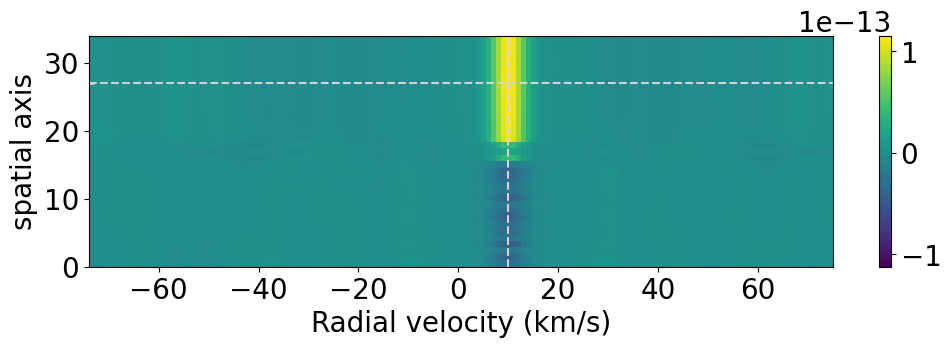

(35, 150)

In [48]:
ccfSum = ccf.sum(axis=0)
ccfWeight = np.sum(medFlux, axis=0)
ccfWeight /= ccfWeight.sum()
nObs = len(ccfWeight)
for iObs in range(nObs): ccfSum[iObs,] -= np.median(ccfSum[iObs,])
plotMatrix(ccfSum, rvlag, np.arange(0, nObs, 1), 'Radial velocity (km/s)','spatial axis',stretch=True, planet_posi=27)
plt.hlines(y=(17+d), xmin=-74, xmax=75, ls='--', colors='lightgray')
plt.vlines(x=10.0, ymin=0, ymax=34, ls='--', colors='lightgray')
plt.show()
ccfSum.shape

<Figure size 1200x300 with 0 Axes>

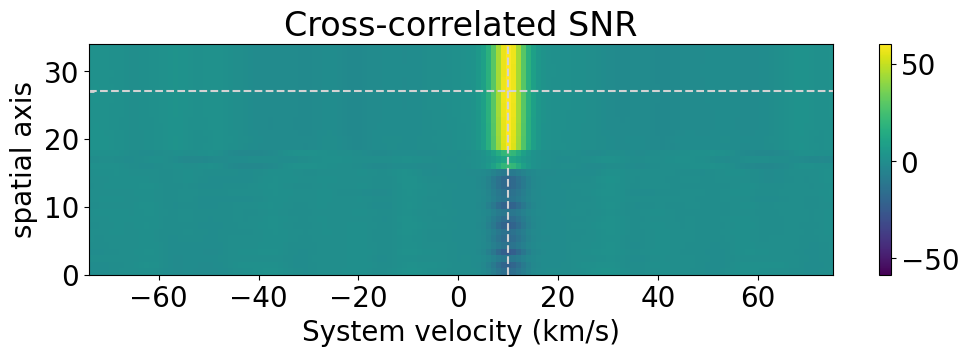

84


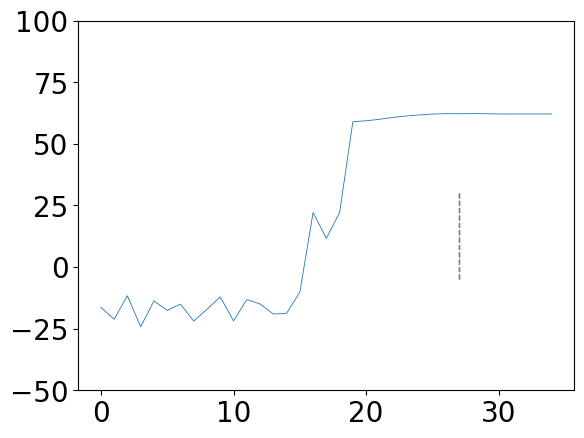

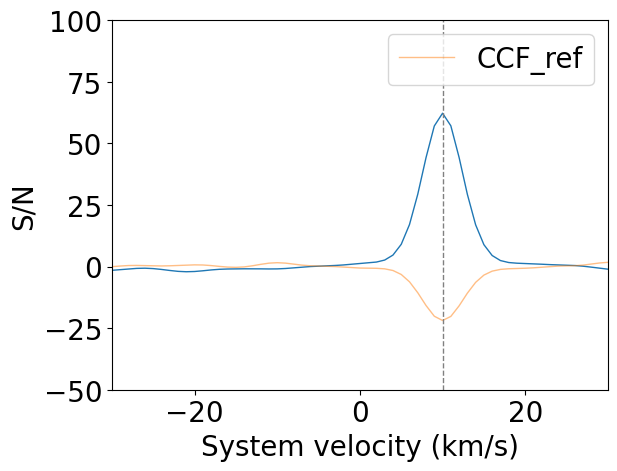

In [49]:
ccfTot=np.zeros(shape=ccfSum.shape)
ccf_empty=np.append(ccfSum[:,0:50], ccfSum[:, 100:150], axis=1)
std = np.nanstd(ccf_empty)

for i in range(ccfSum.shape[0]):
    ccfTot[i]= ccfSum[i]/std

plt.figure(figsize=(12,3))
plotMatrix(ccfTot, rvlag,np.arange(nObs),'System velocity (km/s)','spatial axis',stretch=True, planet_posi=spatial_pix)
plt.hlines(y=(central_pix+d), xmin=-74, xmax=75, ls='--', colors='lightgray')
plt.vlines(x=10.0, ymin=0, ymax=34, ls='--', colors='lightgray')
plt.title ('Cross-correlated SNR')
plt.show()

n=int(np.ceil((np.abs(rvlag.min())+10)/dRV))

print(n)

plt.plot(range(0,35,1), ccfTot[:, n], linewidth=0.6)
plt.vlines(x=spatial_pix, ymin=-5, ymax=30, ls='--', linewidth=1, colors='Gray')
plt.vlines(x=spatial_pix, ymin=-5, ymax=30, ls='--', linewidth=1, colors='Gray')

plt.ylim(-50,100)
plt.show()

plt.plot(rvlag, ccfTot[spatial_pix], linewidth=1)
plt.plot(rvlag, ccfTot[7], linewidth=1, alpha=0.5, label='CCF_ref')

plt.ylim(-50,100)
plt.xlim(-30,30)
plt.vlines(x=10, ymin=-50, ymax=100, ls='--', linewidth=1, colors='Gray')

plt.ylabel('S/N')
plt.xlabel('System velocity (km/s)')

plt.legend()
plt.show()

#plt.plot(rvlag, p)
#plt.ylim(0, 1e4)
#plt.yscale('symlog')

In [ ]:
# Defining vectors for co-adding of the CCFs
nKp = 0
nVr = 0
kpVec = np.arange(nKp) - (nKp-1)//2 + 145     # Centred on the injected RV
vrest = (np.arange(nVr) - (nVr-1)//2)*1.5     # Centred on zero rest-frame velocity

dphi = -0.0077 

def get_velocity_map(ccfSum,ccfW,rvel,ph,dphi):
    ccfTot = np.zeros((nKp,nVr))
    for ikp in range(nKp):
        rvPl = rvel + kpVec[ikp] * np.sin(2.0*np.pi*(ph+dphi))
        for iObs in range(nObs):
            outRV = vrest + rvPl[iObs]
            fit = interpolate.interp1d(rvlag, ccfSum[iObs,])
            ccfTot[ikp,] += fit(outRV)# * ccfWeight[iObs]
    return ccfTot

ccfTot = get_velocity_map(ccfSum,ccfWeight,rvel,np.arange(0,nObs,1),dphi)